# GR 5221 Final Project

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
import datetime as dt

## Section 1: Exloratory Analysis

### 1.1 Load Data

In [3]:
df =  pd.read_csv('all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

### 1.2 Reframe the dataframe
- Choose company `AAL` only
- Choose column `date` and `close`

In [5]:
AAL = df[df['Name'] == 'AAL']
ALL_1 = AAL.loc[:, ['date', 'close']]
ALL_1['date'] = pd.to_datetime(ALL_1['date'], format="%Y-%m-%d")
ALL_1.head()

,date,close
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99


There is no null value in the dataframe.

In [6]:
ALL_1.isnull().sum()

date     0
close    0
dtype: int64

In [7]:
ALL_1.shape

(1259, 2)

### 1.3 Visualization

Text(0.5, 1.0, 'All Close Price History Of AAL')

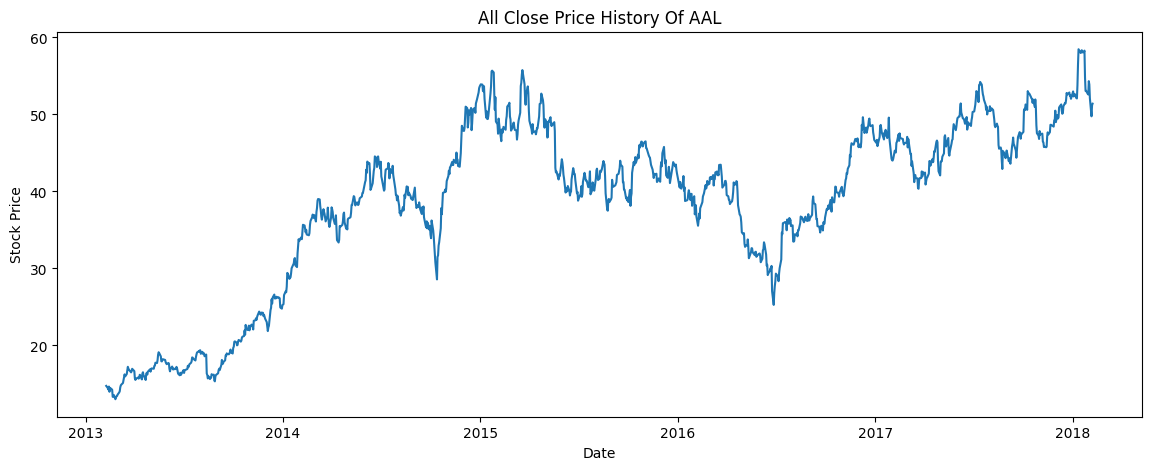

In [8]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ALL_1['date'], ALL_1['close'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_title("All Close Price History Of AAL")

---

#### Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

#### Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [9]:
result = adfuller(ALL_1['close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.066675
p-value: 0.258124


#### p-value: 0.258124 > 0.05, we faill to reject Null hypothesis.

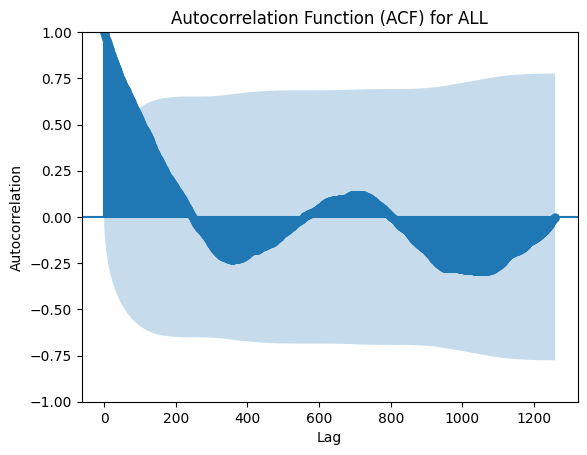

In [10]:
plot_acf(ALL_1['close'], lags=range(1, len(ALL_1['close'])))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for ALL')
plt.show()

### Detrending and Seasonality

In [11]:
y = ALL_1['close']
X = np.arange(len(y)).reshape(-1, 1)

In [12]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [13]:
trend = regressor.predict(X)

In [14]:
len(trend)

1259

In [15]:
ALL_1['trend'] = trend
detrended_data = y - trend

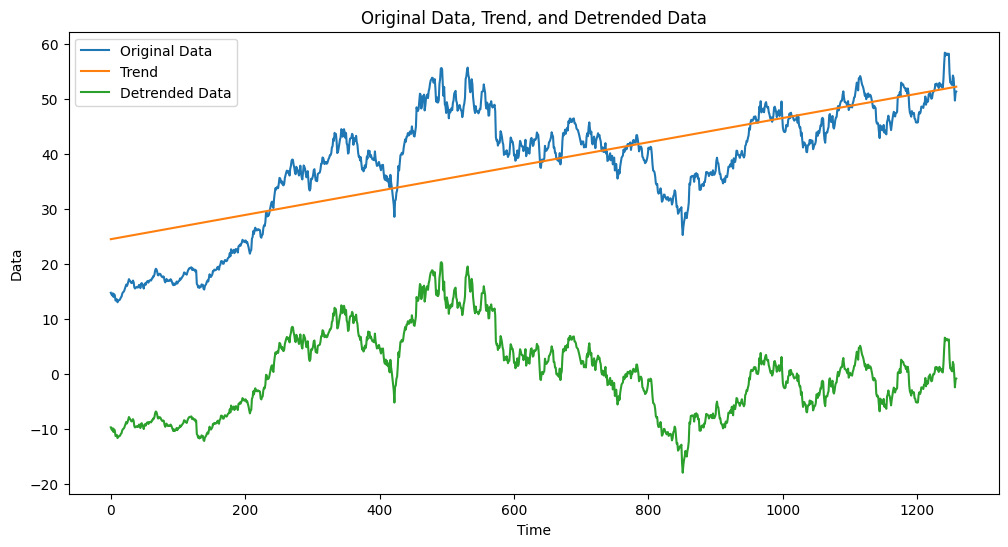

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Original Data')
plt.plot(X, trend, label='Trend')
plt.plot(X, detrended_data, label='Detrended Data')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Original Data, Trend, and Detrended Data')
plt.show()

## Section 2: Time Series Model and Modeling Process 
### 2.1 AR(1) and MA(1)

In [17]:
from statsmodels.tsa.arima.model import ARIMA
# model1 is AR(1)
model1 = ARIMA(ALL_1.close, order = (1,1,0))
# model2 is MA(1)
model2 = ARIMA(ALL_1.close, order = (0,1,1))
model_fit1 = model1.fit()
model_fit2 = model2.fit()

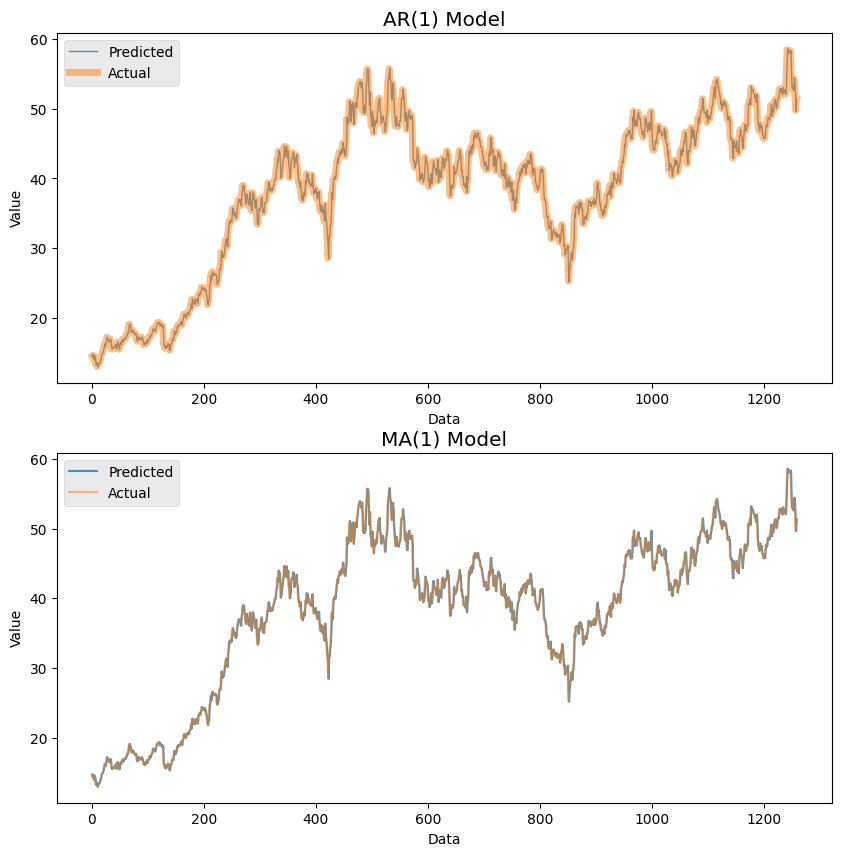

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
pred1 = model_fit1.predict()
pred2 = model_fit2.predict()
plt.style.use('ggplot')

# plot actual values and predicted values
ax1.plot(pred1[1:], label='Predicted', alpha = 0.8 ,linewidth = 1)
ax1.plot(ALL_1.close[1:], label='Actual', alpha = 0.5,linewidth = 5)
ax1.set_title('AR(1) Model')
ax1.set_xlabel('Data')
ax1.set_ylabel('Value')
ax1.legend()


ax2.plot(pred2[1:], label='Predicted', alpha = 0.8)
ax2.plot(ALL_1.close[1:], label='Actual', alpha = 0.5)
ax2.set_title('MA(1) Model')
ax2.set_xlabel('Data')
ax2.set_ylabel('Value')
ax2.legend()

plt.show()

In [19]:
pred1[1:]

1       14.750001
2       14.440891
3       14.257480
4       14.685698
5       13.945852
          ...    
1254    54.433994
1255    53.851007
1256    51.982712
1257    49.605812
1258    51.273567
Name: predicted_mean, Length: 1258, dtype: float64

In [20]:
ALL_1.close[1:]

1       14.46
2       14.27
3       14.66
4       13.99
5       14.50
        ...  
1254    53.88
1255    52.10
1256    49.76
1257    51.18
1258    51.40
Name: close, Length: 1258, dtype: float64

The lower the value of the Root Mean Squared Error, the better the model is.(...)

In [21]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ALL_1.close[1:], pred1[1:]))
rmse2 = np.sqrt(mean_squared_error(ALL_1.close[1:], pred2[1:]))
print(f'The Root Mean Squared Error for AR(1) model is {rmse}\nThe Root Mean Squared Error for MA(1) model is {rmse2}')

The Root Mean Squared Error for AR(1) model is 0.8646704398975732
The Root Mean Squared Error for MA(1) model is 0.8647742633780344


## 2.3 ARIMA

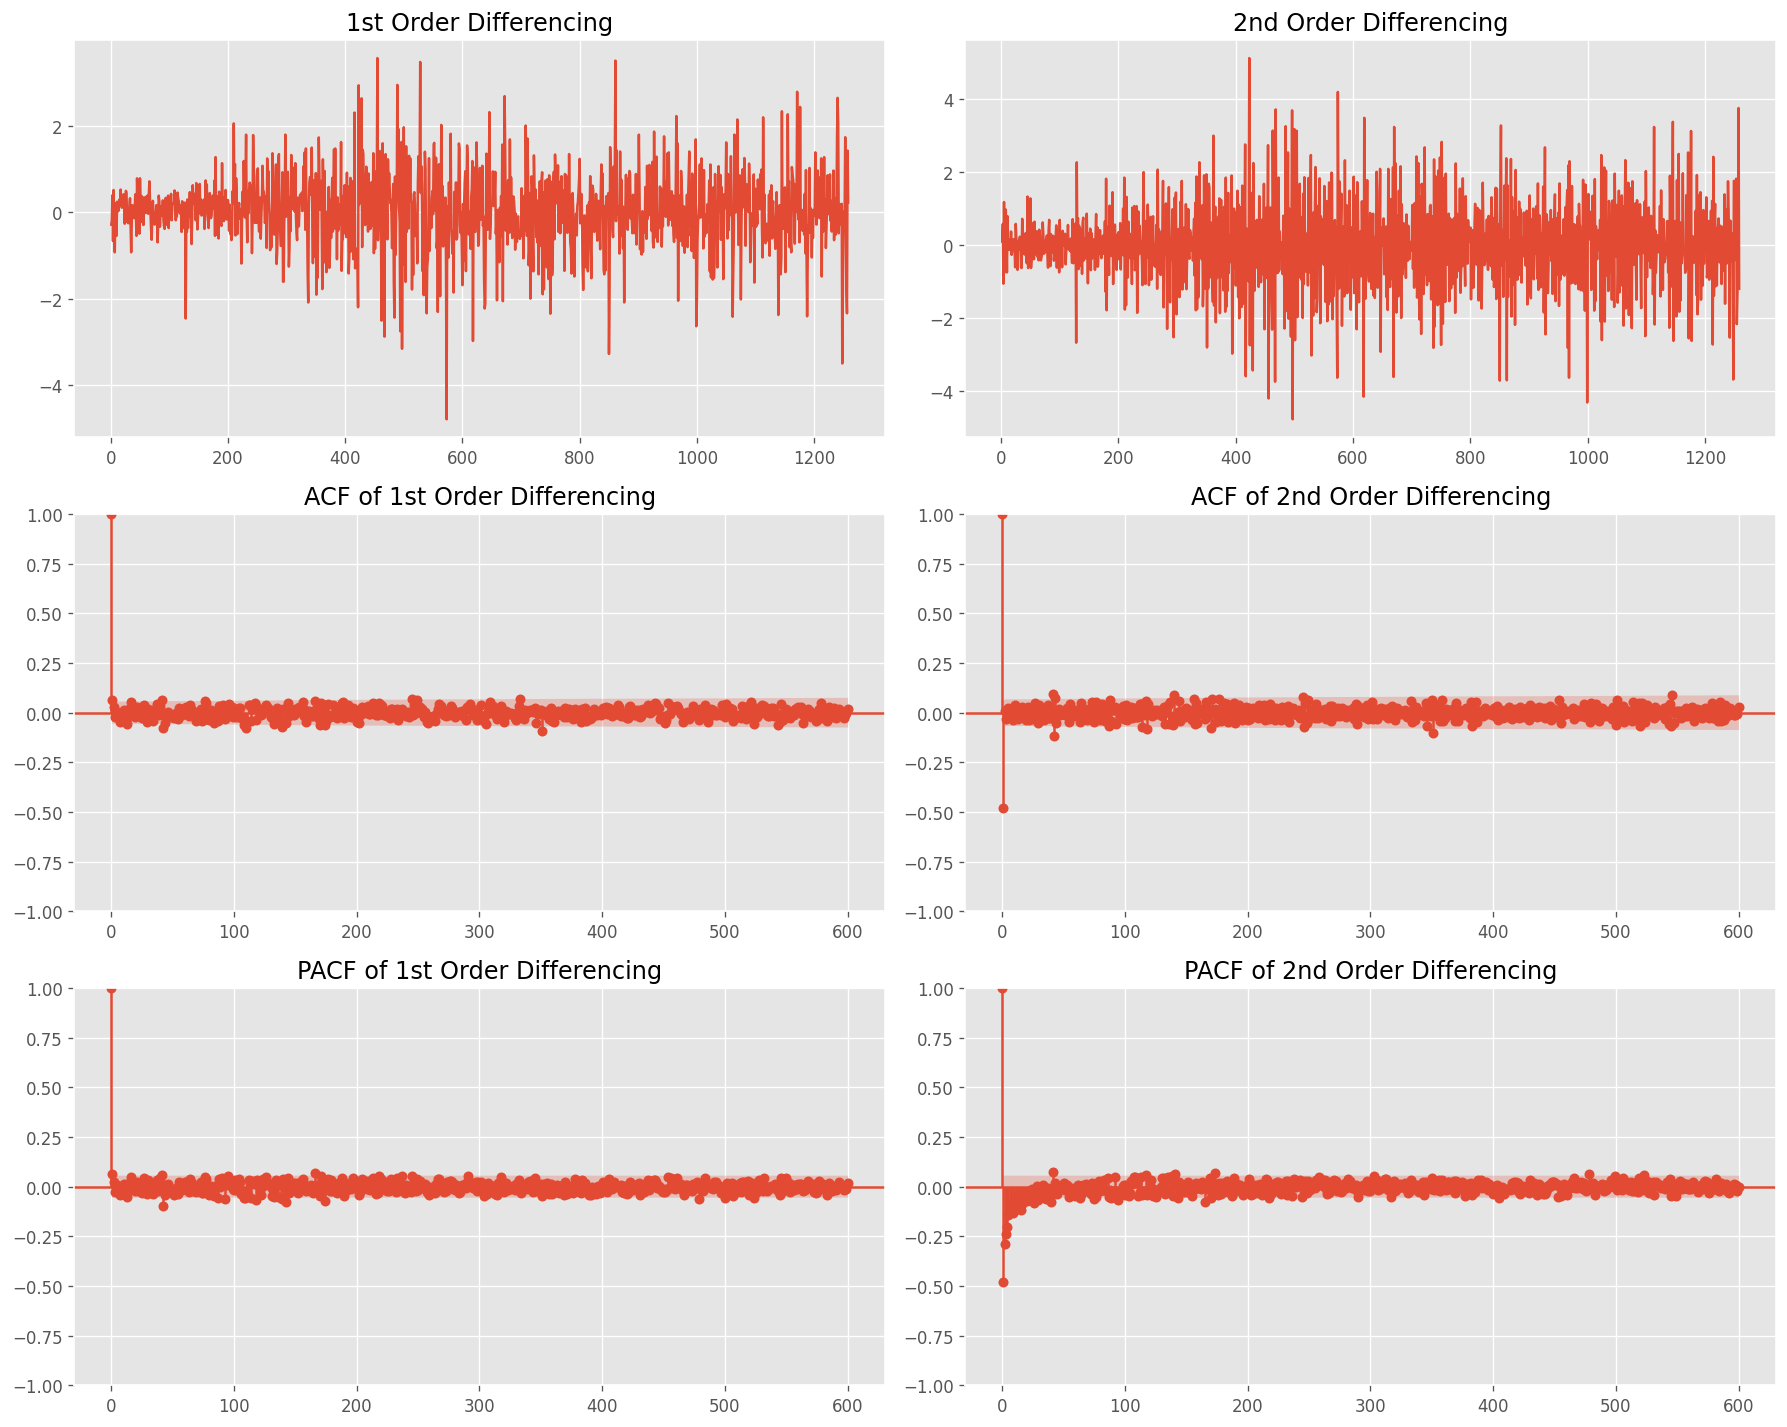

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), dpi=120)

#1st Order Differencing
axes[0, 0].plot(ALL_1.close.diff().dropna());axes[0, 0].set_title('1st Order Differencing')

plot_acf(ALL_1.close.diff().dropna(), ax=axes[1, 0], lags=600)
axes[1, 0].set_title('ACF of 1st Order Differencing')

plot_pacf(ALL_1.close.diff().dropna(), method='ywm',ax=axes[2, 0], lags=600)
axes[2, 0].set_title('PACF of 1st Order Differencing')


#2nd Order Differencing
axes[0, 1].plot(ALL_1.close.diff().diff().dropna());axes[0, 1].set_title('2nd Order Differencing')

plot_acf(ALL_1.close.diff().diff().dropna(), ax=axes[1, 1], lags=600)
axes[1, 1].set_title('ACF of 2nd Order Differencing')

plot_pacf(ALL_1.close.diff().diff().dropna(), method='ywm',ax=axes[2, 1], lags=600)
axes[2, 1].set_title('PACF of 2nd Order Differencing')



fig.tight_layout()
plt.show()


- From above plots, we can see that the time series reaches stationarity with one orders of differencing.

#### Dickey-Fuller test

- For 1st Order Differencing|

In [23]:
result_1 = adfuller(ALL_1.close.diff().dropna())
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

ADF Statistic: -33.199423
p-value: 0.000000


- For 2nd Order Differencing

In [24]:
result_2 = adfuller(ALL_1.close.diff().diff().dropna())
print('ADF Statistic: %f' % result_2[0])
print('p-value: %f' % result_2[1])

ADF Statistic: -13.149203
p-value: 0.000000


#### From Dickey_fuller test both difference are stationary

---

In [25]:
model3 = ARIMA(ALL_1.close, order = (1,1,1))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1601.880
Date:                Tue, 25 Apr 2023   AIC                           3209.761
Time:                        20:30:27   BIC                           3225.173
Sample:                             0   HQIC                          3215.553
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2768      0.346      0.800      0.424      -0.402       0.955
ma.L1         -0.2107      0.352     -0.599      0.549      -0.901       0.479
sigma2         0.7474      0.021     36.346      0.0

In [26]:
model3 = ARIMA(ALL_1.close, order = (1,1,3))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1600.415
Date:                Tue, 25 Apr 2023   AIC                           3210.830
Time:                        20:30:28   BIC                           3236.516
Sample:                             0   HQIC                          3220.483
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8472      0.164      5.181      0.000       0.527       1.168
ma.L1         -0.7838      0.164     -4.791      0.000      -1.104      -0.463
ma.L2         -0.0237      0.035     -0.683      0.4

In [27]:
model3 = ARIMA(ALL_1.close, order = (2,1,3))
model_fit3 = model3.fit()
print(model_fit3.summary())

C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1598.475
Date:                Tue, 25 Apr 2023   AIC                           3208.950
Time:                        20:30:29   BIC                           3239.774
Sample:                             0   HQIC                          3220.534
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6945      0.023    -30.563      0.000      -0.739      -0.650
ar.L2         -0.9706      0.021    -45.699      0.000      -1.012      -0.929
ma.L1          0.7566      0.034     22.534      0.0

C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
residuals = pd.DataFrame(model_fit3.resid)

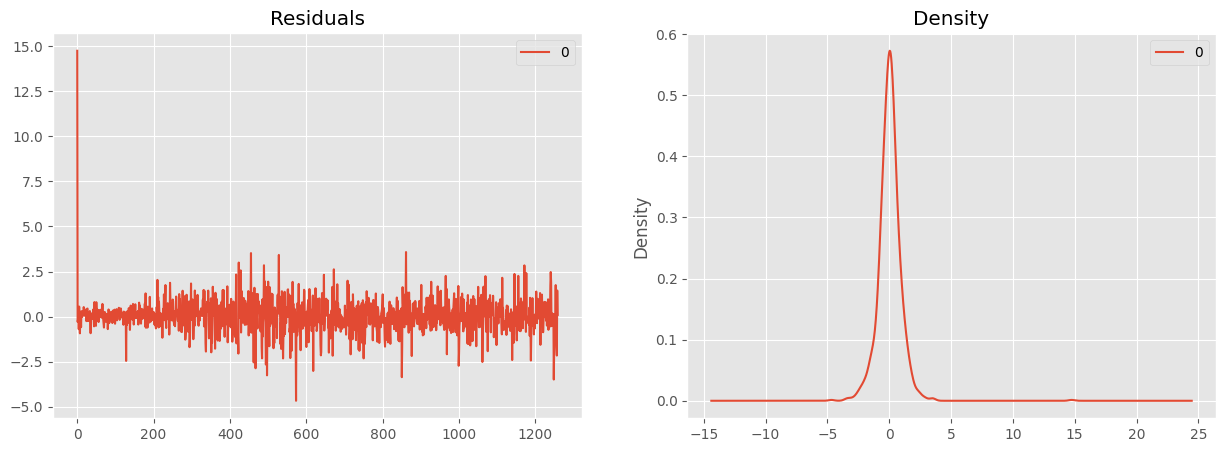

In [29]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### AIC

In [30]:
best_p = None
best_q = None
best_aic = np.inf

# Define the range of values for p and q to search over
p_values = range(0, 6) # Example: searching for p values from 0 to 5
q_values = range(0, 6) # Example: searching for q values from 0 to 5

for p in p_values:
    for q in q_values:
        try:
            # Fit ARIMA model with current p and q values
            model = ARIMA(ALL_1.close, order=(p, 1, q)) # Assuming d=1 (i.e., first-order differencing)
            model_fit = model.fit()
            aic = model_fit.aic
            
            # Update best p and q values if current AIC is better
            if aic < best_aic:
                best_p = p
                best_q = q
                best_aic = aic

        except:
            continue

print("Best p:", best_p)
print("Best q:", best_q)

C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge

Best p: 1
Best q: 0


C:\Users\daizi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Auto arima to choose q and p

In [31]:
from pmdarima.arima import auto_arima

In [32]:
model = auto_arima(ALL_1.close, seasonal=True, suppress_warnings=True,
                   stepwise=True, trace=True, error_action="ignore", 
                   max_order=None, suppress_stderr=False, 
                   random_state=None, n_fits=10)

# Print the optimal ARIMA model order
print("Best ARIMA model order: (p, d, q) =", model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3212.973, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3212.261, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3208.962, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3209.245, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3211.684, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3210.192, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3210.554, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3211.797, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3208.210, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3209.380, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3209.761, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3208.511, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3211.060, Time=0.50 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.501 seconds
Best ARIMA model order

In [33]:
model3 = ARIMA(ALL_1.close, order = (1,1,0))
model_fit3 = model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1602.105
Date:                Tue, 25 Apr 2023   AIC                           3208.210
Time:                        20:31:01   BIC                           3218.484
Sample:                             0   HQIC                          3212.071
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0659      0.025      2.680      0.007       0.018       0.114
sigma2         0.7476      0.021     36.365      0.000       0.707       0.788
Ljung-Box (L1) (Q):                   0.01   Jarque-

## Section 3: Forecasting

### 4.1 Forecasting using ARIMA

In [55]:
from statsmodels.tsa.stattools import acf

In [56]:
train_size = 0.8  
train, test = train_test_split(ALL_1.close, train_size=train_size, shuffle=False)

In [57]:
model5 = ARIMA(train, order=(1, 1, 0))  
fitted = model5.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1007
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1273.487
Date:                Tue, 25 Apr 2023   AIC                           2550.974
Time:                        20:36:05   BIC                           2560.801
Sample:                             0   HQIC                          2554.708
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.027      2.508      0.012       0.015       0.121
sigma2         0.7363      0.022     33.275      0.000       0.693       0.780
Ljung-Box (L1) (Q):                   0.01   Jarque-

fc = fitted.forecast(15, alpha=0.05)

In [124]:
fc = fitted.forecast(steps=len(test))

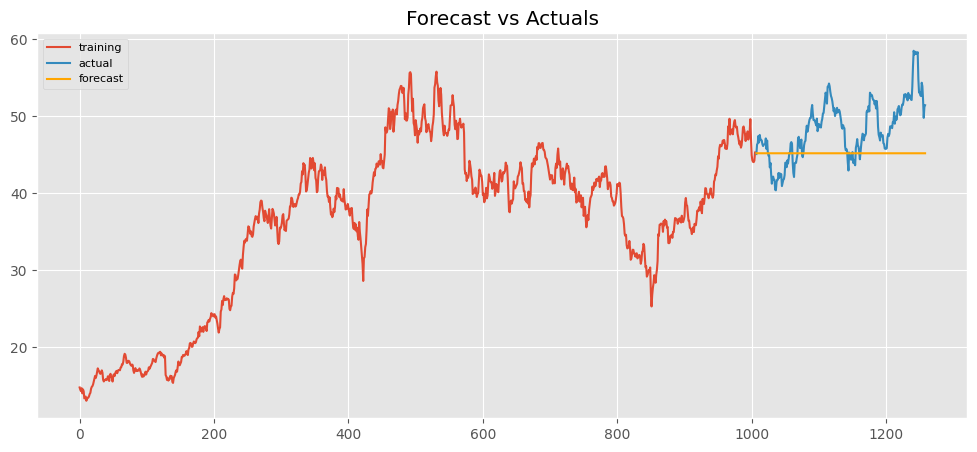

In [126]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast',color='orange')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4.2 Forecasting using LSTM

In [122]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load stock price data
df = ALL_1
prices = df['close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Split data into train and test sets
train_size = int(len(prices_scaled) * 0.8)
test_size = len(prices_scaled) - train_size
train_data = prices_scaled[0:train_size, :]
test_data = prices_scaled[train_size:len(prices_scaled), :]

# Function to create dataset for LSTM
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        data_X.append(dataset[i:(i + time_steps), 0])
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)

# Create training dataset
time_steps = 20 # Change this value to adjust the time steps
X_train, y_train = create_dataset(train_data, time_steps)

# Create test dataset
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predicted values to original scale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)




Epoch 1/10
31/31 [==============================] - 5s 17ms/step - loss: 0.0375
Epoch 2/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 3/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 4/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 5/10
31/31 [==============================] - 1s 16ms/step - loss: 0.0020
Epoch 6/10
31/31 [==============================] - 1s 18ms/step - loss: 0.0020
Epoch 7/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 8/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 9/10
31/31 [==============================] - 1s 17ms/step - loss: 0.0018
Epoch 10/10
8/8 [==============================] - 0s 6ms/step


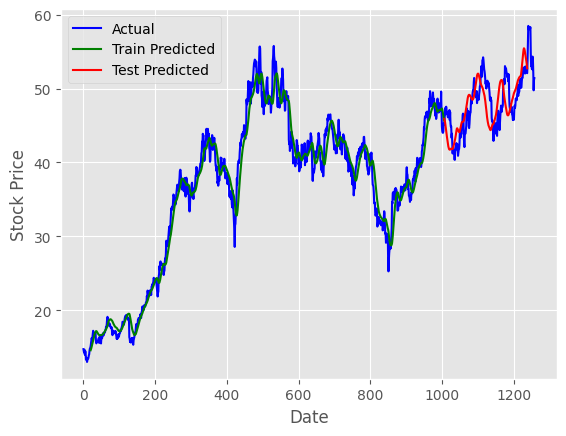

In [123]:
# Plot actual vs predicted stock prices
plt.plot(prices, color='blue', label='Actual')
plt.plot(range(time_steps, len(y_train_pred) + time_steps), y_train_pred, color='green', label='Train Predicted')
plt.plot(range(time_steps + len(y_train_pred), len(y_train_pred) + time_steps + len(y_test_pred)), y_test_pred, color='red', label='Test Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Section 5: ~